> 출처: https://www.youtube.com/watch?v=ylS-snJrX2g

# 1. 이해하기
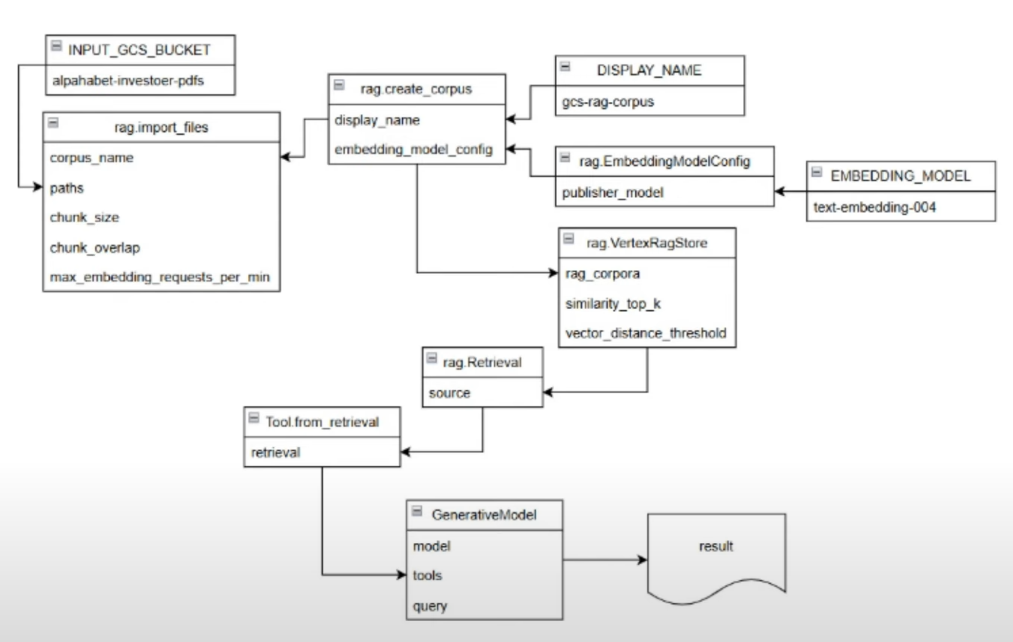

## 1. corpus 만들기
1. corpus를 만들기 위해서 EMBEDDING_MODEL에 대한 정보와 corpus 이름에 대한 정보(DISPLAY_NAME)를 넣어주기
2.  모델 정보는 EmbeddingModelConfig라는 함수를 통해서 create_corpus에 전달해주면 corpus가 만들어짐

## 2. corpus에 GCS에 있는 정보 넣기
1. `INPUT_GCS_BUCKET` GCS에 있는 정보를 넣기 위해서 버킷 정보 만들기
2. `rag.import_files` import_files라는 함수에 GCS에 대한 정보와 corpus 정보(display_name, embedding_model_config)를 전달하고, 거기에 chuck_size, chuck_overlap, max_embedding_requests_per_min 정보를 전달하기
    - chuck_size: 데이터를 전송할 때 변환되는 데이터의 크기
    - chuck_overlap: 중첩된 데이터에 대한 사이즈
    - max_embedding_requests_per_min: embedding model을 호출할 때의 속도를 제한하기 위해 사용

## 3. 모델 돌리기
1. `VertexRagStore` VertexRagStore에 courpus 정보 얻어오기
2. `rag.Retrieval` 얻어온 정보를 가지고 retrieval하기
3. `Tool.from_retrival` from_retrieval해서 tool로 만들기
4. `GenerativeModel` GenerativeModel에서 tool 이용해서 쿼리를 하게 되면 결과가 나오게 됨

# 2. 환경설정
> 출처: https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/rag-engine/intro_rag_engine.ipynb?hl=ko#scrollTo=cf93d5f0ce00

*유튜브 코드 따라 하면 PROJECT_ID가 None으로 나오고 오류 발생ㅠ 왜 안 되는거야*

## 2.1 Install Vertex AI SDK and Google Gen AI SDK

In [ ]:
%pip install --upgrade --quiet google-cloud-aiplatform google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 14.2 MB/s eta 0:00:00


## 2.2 Authenticate your notebook environment

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

## 2.3 Set Google Cloud project information and initialize Vertex AI SDK

In [1]:
# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai
from google import genai

# fmt: off
PROJECT_ID = "todak-for-daily"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
# fmt: on
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

# See https://cloud.google.com/vertex-ai/generative-ai/docs/rag-engine/rag-overview#supported-regions for location options.
vertexai.init(project=PROJECT_ID, location="us-east4")
client = genai.Client(vertexai=True, project=PROJECT_ID, location="global")

## 2.4 Import libraries

In [2]:
from IPython.display import Markdown, display
from google.genai.types import GenerateContentConfig, Retrieval, Tool, VertexRagStore
from vertexai import rag

# 3. RAG 구현

## 3.1 RAG Corpus 생성
유튜브 코드 말고 Vertex ai RAG engine 가이드 코드 사용함

In [ ]:
# # Currently supports Google first-party embedding models
# # fmt: off
# EMBEDDING_MODEL = "publishers/google/models/text-embedding-005"  # @param {type:"string", isTemplate: true}
# # fmt: on

# rag_corpus = rag.create_corpus(
#     display_name="my-rag-corpus",
#     backend_config=rag.RagVectorDbConfig(
#         rag_embedding_model_config=rag.RagEmbeddingModelConfig(
#             vertex_prediction_endpoint=rag.VertexPredictionEndpoint(
#                 publisher_model=EMBEDDING_MODEL
#             )
#         )
#     ),
# )

In [ ]:
# rag.list_corpora()

ListRagCorporaPager<rag_corpora {
  name: "projects/todak-for-daily/locations/us-east4/ragCorpora/2305843009213693952"
  display_name: "my-rag-corpus"
  create_time {
    seconds: 1761052056
    nanos: 349917000
  }
  update_time {
    seconds: 1761052056
    nanos: 349917000
  }
  corpus_status {
    state: ACTIVE
  }
  vector_db_config {
    rag_managed_db {
      knn {
      }
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/todak-for-daily/locations/us-east4/publishers/google/models/text-embedding-005"
      }
    }
  }
}
>

In [3]:
rag_corpus_name = "projects/todak-for-daily/locations/us-east4/ragCorpora/2305843009213693952"
rag_corpus = rag.get_corpus(rag_corpus_name)
print("USING CORPUS:", rag_corpus.name)

USING CORPUS: projects/todak-for-daily/locations/us-east4/ragCorpora/2305843009213693952


## 3.2 upload

### 3.2.1 import files from GCS

- GCS(Google Cloud Storage)란?
  - Google Cloud Platform(GCP)에서 제공하는 파일 저장소 서비스
  - **클라우드상의 폴더(디스크 드라이브)** 라고 생각하면 됨

- Bucket(버킷)이란?
  - GCS에서 모든 파일은 “버킷(bucket)”이라는 단위 폴더 안에 저장됨
  - **버킷 = 클라우드 상의 폴더/저장공간**
  - **객체(object)** = 실제 파일(예: PDF, CSV, 이미지 등)

  > my_dataset.csv 같은 파일이 GCS에 올라가면
  > <br>그건 my-bucket이라는 버킷 안에 들어있는 구조인 것
  > <br>`gs://my-bucket/my_dataset.csv`
  >  - `gs://`: GCS 프로토콜
  >  - `my-bucket`: 버킷 이름
  >  - `my_dataset.csv`: 실제 파일 이름

- 버킷 만들기: https://console.cloud.google.com/storage/browser?project=recommendactions&prefix=&forceOnObjectsSortingFiltering=false&forceOnBucketsSortingFiltering=true&bucketType=live
  > 버킷과 corpus의 리전이 동일해야 된다고 함
  

  > Vertex RAG Engine이 GCS 파일을 읽으려면,**viewer 권한을 부여**해서 RAG 서비스 계정이 파일을 읽을 수 있도록 해야 함
  > <br>`service-{project_number}@gcp-sa-vertex-rag.iam.gserviceaccount.com`


  > 버킷에 아무 파일도 없으면 밑에 코드 오류 남. 파일이 있어야 함
  > <br>그래서 `recommendactions-bucket/data-pdf/발달장애인의+도전적+행동+중재+매뉴얼(웹게시용).pdf`을 업로드 함


> 파일 최대 크기는 25MB임 <br> (updf 사용해서 파일 분할함. 최대 크기 10MB로 해서 분할했음)<br>
> 출처: https://docs.cloud.google.com/vertex-ai/generative-ai/docs/rag-engine/use-data-ingestion?utm_source=chatgpt.com&hl=ko

In [ ]:
# # 버킷에 샘플 파일 하나를 업로드하기

# # 예시 파일 생성
# !echo "This is a test document for RAG import." > sample.txt

# # 파일 업로드
# !gcloud storage cp sample.txt gs://todak-bucket/

In [ ]:
# # 업로드 됐는지 확인하기
# !gcloud storage ls gs://todak-bucket/

In [ ]:
# # 버킷에 샘플 파일 하나를 업로드하기

# # 예시 파일 생성
# !echo "발달장애의 개념은 발달장애인 권리보장 및 지원에 관한 법률에 자세하게 업급되어 있습니다. 법에는 지적장애와 자폐성장애, 그밖에 통상적인 발달이 나타나지 않거나 지연되어 일상생활이나 사회생활에 상당한 제약을 받는 사람들로 정의되어 있습니다. 발달장애의 진단적 특징은 인지적, 행동적 장애로 인한 특정한 지적, 운동적, 사회적 기능을 획득하거나 실행하는 데 어려움이 있다는 것입니다. 따라서 자기가 원하거나 필요로 하는 것을 제대로 표현하고 소통하기 어렵다는 진단적 특성을 이해할 필요가 있습니다. 발달장애인이 가진 주의집중의 어려움, 성행동 문제, 낮은 학습동기, 의사소통의 어려움 등의 고유한 특성으로 인해 도전적 행동이 발생할 수 있습니다. 도전적 행동과 관련된 발달장애인의 특성은 건강, 감각 행동적인 특성이 있습니다. " > test.txt

# # 파일 업로드
# !gcloud storage cp test.txt gs://todak-bucket/

Copying file://test.txt to gs://todak-bucket/test.txt


In [ ]:
# # 업로드 됐는지 확인하기
# !gcloud storage ls gs://todak-bucket/

gs://todak-bucket/test.txt
gs://todak-bucket/test_pdf.pdf
gs://todak-bucket/발달장애인의+도전적+행동+중재+매뉴얼(웹게시용)_부산대학교/


In [21]:
INPUT_GCS_BUCKET = "gs://todak-bucket"

response = rag.import_files(
    corpus_name=rag_corpus.name,
    paths=[INPUT_GCS_BUCKET],
    # Optional
    transformation_config=rag.TransformationConfig(
        chunking_config=rag.ChunkingConfig(chunk_size=1024, chunk_overlap=100)
    ),
    max_embedding_requests_per_min=900,  # Optional
)

### 3.2.2 결과 확인하기

In [16]:
# Direct context retrieval
response = rag.retrieval_query(
    rag_resources=[
        rag.RagResource(
            rag_corpus=rag_corpus.name,
            # Optional: supply IDs from `rag.list_files()`.
            # rag_file_ids=["rag-file-1", "rag-file-2", ...],
        )
    ],
    # rag_retrieval_config=rag.RagRetrievalConfig(
    #     top_k=10,  # Optional
    #     filter=rag.Filter(
    #         vector_distance_threshold=0.5,  # Optional
    #     ),
    # ),

    # 쿼리 내용
    text="발달장애인이란?"
)
print(response)

# Optional: The retrieved context can be passed to any SDK or model generation API to generate final results.
# context = " ".join([context.text for context in response.contexts.contexts]).replace("\n", "")

contexts {
  contexts {
    source_uri: "gs://todak-bucket/서울시장애인권익옹호기관_발달장애인도전적행동지원가이드.pdf"
    text: "그렇다면 이 행동은 조절에 도움이 되는가, 아니면 더 심해져서 \r\n조절을 방해하는가?\r\n·제한된 식이요법 등의 여러 이유로 욕구 불만인 상태인가? \r\n·체력적으로 피곤한가? \r\n(2) 활동참여 정보 수집\r\n이용인의 신체기능과 건강 관련 정보가 수집되었다면 다음으로 이용인의 일상 활동\r\n과 참여에 대한 정보를 수집한다. 활동참여에 대한 정보를 수집하기 위해서는 먼저 \r\n활동과 행동에 대한 이해가 필요하고, 활동참여의 종류 및 균형과 속성에 대한 지식\r\n도 요구된다. 활동참여에 대한 충분한 이해와 지식을 바탕으로 수집해야 할 정보의 \r\n내용은 다음과 같다. \r\n활동참여 관련 정보 수집\r\n·일과의 루틴활동이 달라진 점이 있는가?\r\n·일상생활에서 예측하기 힘든 이벤트가 과도한가?\r\n·일상생활의 활동 균형은 잘 유지되는가? 예를 들어 놀이나 여가활동이 충분하면서 의무적인 \r\n활동과 기대되는 활동을 파악한 일상생활 활동이 이루어지는가? 아니면 무계획적이고 무작위\r\n적으로 원하는 활동만 너무 많이 하는가? 088\r\n활동참여 관련 정보 수집\r\n·개인의 선호도와 활동이 알맞게 연결되는가? 어떤 사람의 경우 실내 활동을 더 선호하는 데 비\r\n해 외부 활동이 너무 많은 편인가? \r\n·활동이 빈약한가? \r\n·활동이 너무 많은가? \r\n·활동의 난이도가 너무 어려운가? 지루해지기 쉬운가? \r\n·활동 참여를 하는 방식을 이해하고 있는가? 예를 들면 많은 발달장애인은 시범 없는 시도를 하\r\n기 어려워하기 때문에 시범을 보이는 다른 사람의 행동을 보고 난 다음 활동이 시작된 중간에 \r\n참여하는 경우가 있는데 이런 활동 참여 방식을 서로 이해하고 있는가? \r\n·활동의 의미와 목적에 대해 공유되지 않고 소통이 어려운가?\r

# 4. 모델

## 4.1 모델 만들기

In [22]:
from vertexai.preview.generative_models import (
    GenerativeModel,
    Tool
)
source=rag.VertexRagStore(
      rag_resources=[rag.RagResource(rag_corpus=rag_corpus.name)],
      rag_retrieval_config=rag.RagRetrievalConfig(
          top_k=10,  # Optional
          filter=rag.Filter(
              vector_distance_threshold=0.5,  # Optional
          ),
      ),
)

retrieval = rag.Retrieval(source=source)
rag_retrieval_tool = Tool.from_retrieval(retrieval)

In [23]:
rag_gemini_model = GenerativeModel(
    "gemini-2.0-flash-lite",
    tools=[rag_retrieval_tool]
)

In [10]:
query="""
발달장애인과 정상인의 차이점은 무엇인가요? 간결하게 한 문장으로 말해주세요.
수집한 pdf 파일 url 출력
"""

response = rag_gemini_model.generate_content(query)

response.text

'발달장애인은 지적인 능력과 사회적 상호작용의 질적인 결함으로 인해 다른 사람과의 소통이 어려울 수 있습니다.\ngs://todak-bucket/서울시장애인권익옹호기관_발달장애인도전적행동지원가이드.pdf\n'

In [27]:
query="""
밑의 상황은 발달장애인이 현재 어려움을 겪고 있는 상황입니다.
발달장애인인 사용자의 현재 감정은 "힘들어서 도움이 필요해요"입니다.
사용자가 겪고 있는 현재 상황은 "시끄러워요"입니다.
사용자의 습관은 "소음에 민감해요, 버스 번호가 바뀌면 불안해요, 옷을 입는 순서가 정해져 있어요, 항상 같은 그릇을 사용해서 밥을 먹어요, 사람과 닿는 게 부담스러워요"입니다.
사용자의 현재 일정은 "출근하기"입니다.

이 상황("출근하기"를 하고 있는데 "시끄러워요"라는 상황을 겪어 "힘들어서 도움이 필요하다"는 감정을 느끼는 상황)에서 사용자의 감정을 낮춰 줄 수 있는 행동을 세 가지 추천해주세요.
추천 행동은 반드시 현재 사용자의 상황에서 사용자가 바로 실천할 수 있는 행동이어야 합니다.
발달장애인이 이해하기 쉬운 단어로 간결하게 한 문장으로 말해주세요.
3가지의 추천 행동을 1. ~하기, 2. ~하기, 3.~하기로 번호로 나타내 주세요.
수집한 pdf 파일 url 출력해주세요.
"""

response = rag_gemini_model.generate_content(query)

response.text

'1. 조용한 곳에서 잠시 숨을 고르기, 2. 좋아하는 음악을 듣기, 3. 귀를 막아 소리를 줄이기.\n\ngs://todak-bucket/서울시장애인권익옹호기관_발달장애인도전적행동지원가이드.pdf\n'

In [15]:
query="""
밑의 상황은 발달장애인이 현재 어려움을 겪고 있는 상황입니다.
발달장애인인 사용자의 현재 감정은 "힘들어서 도움이 필요해요"입니다.
사용자가 겪고 있는 현재 상황은 "시끄러워요"입니다.
사용자의 습관은 "소음에 민감해요, 버스 번호가 바뀌면 불안해요, 옷을 입는 순서가 정해져 있어요, 항상 같은 그릇을 사용해서 밥을 먹어요, 사람과 닿는 게 부담스러워요"입니다.
사용자의 현재 일정은 "출근하기"입니다.

이 상황("출근하기"를 하고 있는데 "시끄러워요"라는 상황을 겪어 "힘들어서 도움이 필요하다"는 감정을 느끼는 상황)에서 사용자의 감정을 낮춰 줄 수 있는 행동을 세 가지 추천해주세요.
추천 행동은 반드시 현재 사용자의 상황에서 사용자가 바로 실천할 수 있는 행동이어야 합니다.
발달장애인이 이해하기 쉬운 단어로 간결하게 한 문장으로 말해주세요.
3가지의 추천 행동을 1. ~하기, 2. ~하기, 3.~하기로 번호로 나타내 주세요.
수집한 pdf 파일 url 출력해주세요.
"""

response = rag_gemini_model.generate_content(query)

response.text

'1. 좋아하는 노래를 작게 틀어 소음을 줄이기, 2. 평소 입는 옷을 입고, 정해진 순서대로 입기, 3. 사람과 닿지 않도록, 이동 시 공간을 확보하기.\n\ngs://todak-bucket/서울시장애인권익옹호기관_발달장애인도전적행동지원가이드.pdf\ngs://todak-bucket/2022 발달장애인 어려운행동 컨설팅 매뉴얼최종본.pdf\n'